## Делаем подмодельку

In [6]:
import geopandas as gpd
import networkx as nx
from blocksnet import AdjacencyCalculator
import osmnx as ox
from shapely import Point, LineString, length

SPEED = 4 * 1000 / 60

def parse_node(node : str):
  res = node
  res = res.removeprefix('(')
  res = res.removesuffix(')')
  x,y = res.split(', ')
  return Point(x,y)

def get_blocks(file_name):
  blocks = gpd.read_file(file_name)
  blocks['area'] = blocks.area
  blocks['land_use'] = None
  # blocks = blocks.sort_values('area').head(len(blocks)-4)
  return blocks
def get_adj_mx(file_name, blocks):
  graph = nx.read_graphml(file_name)
  graph.graph['crs'] = blocks.crs
  for node, data in graph.nodes(data=True):
    point = parse_node(node)
    data['x'] = point.x
    data['y'] = point.y
  for u, v, data in graph.edges(data=True):
    point_u = parse_node(u)
    point_v = parse_node(v)
    line_string = LineString([point_u, point_v])
    data['transport_type'] = 'drive'
    data['weight'] = length(line_string)/SPEED
  ac = AdjacencyCalculator(blocks=blocks, graph=graph)
  return ac.run()  

In [7]:
from blocksnet import City

blocks_lu = get_blocks('sveto.geojson')
adj_mx = get_adj_mx('sveto_graph.graphml', blocks_lu)
city = City(blocks_lu, adj_mx) 

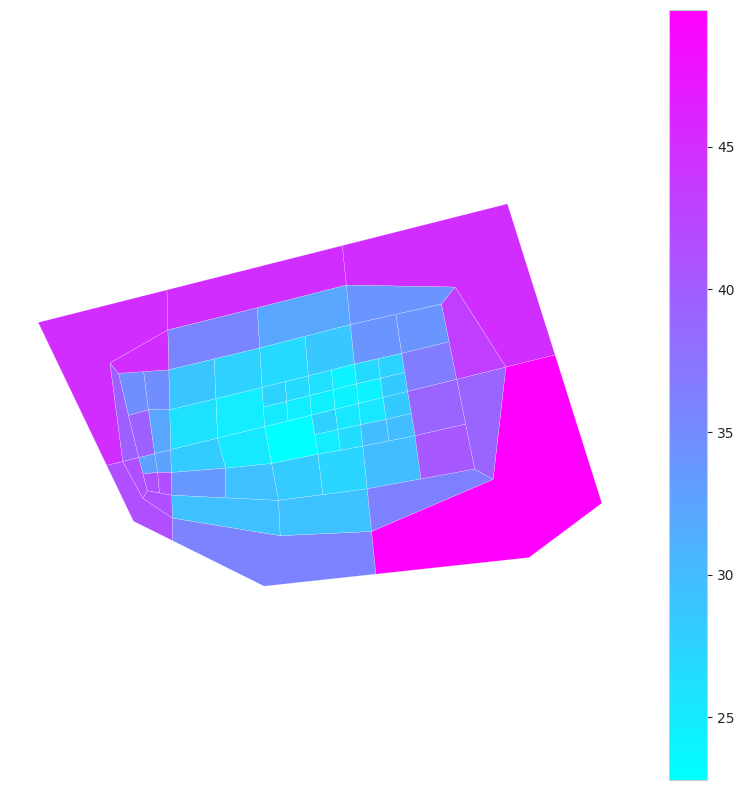

In [8]:
from blocksnet import Connectivity

Connectivity.plot(Connectivity(city_model=city).calculate())

## Annealing

100%|██████████| 1/1 [00:07<00:00,  7.39s/it]


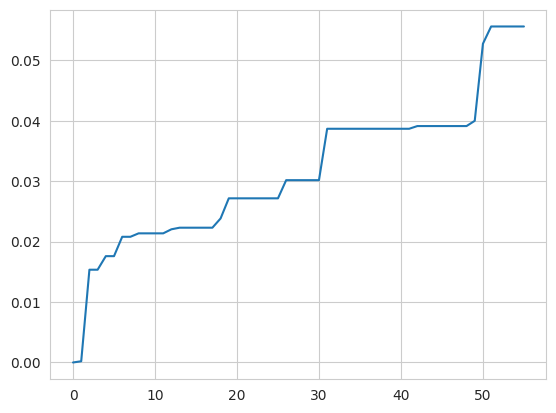

In [9]:
import random
from blocksnet.method.annealing_optimizer import AnnealingOptimizer
from blocksnet.models import LandUse
from loguru import logger
import matplotlib.pyplot as plt

class Indicator:
    def __init__(self, fsi_min, fsi_max, gsi_min, gsi_max):
        self.fsi_min = fsi_min  # минимальный коэффициент плотности застройки
        self.fsi_max = fsi_max  # максимальный коэффициент плотности застройки
        self.gsi_min = gsi_min  # минимальный процент застроенности участка
        self.gsi_max = gsi_max  # максимальный процент застроенности участка

LU_INDICATORS = {
    LandUse.RESIDENTIAL: Indicator(fsi_min=0.5, fsi_max=3.0, gsi_min=0.2, gsi_max=0.8),
    LandUse.BUSINESS: Indicator(fsi_min=1.0, fsi_max=3.0, gsi_min=0.0, gsi_max=0.8),
    LandUse.RECREATION: Indicator(fsi_min=0.05, fsi_max=0.2, gsi_min=0.0, gsi_max=0.3),
    LandUse.SPECIAL: Indicator(fsi_min=0.05, fsi_max=0.2, gsi_min=0.05, gsi_max=0.15),
    LandUse.INDUSTRIAL: Indicator(fsi_min=0.3, fsi_max=1.5, gsi_min=0.2, gsi_max=0.8),
    LandUse.AGRICULTURE: Indicator(fsi_min=0.1, fsi_max=0.2, gsi_min=0.0, gsi_max=0.6),
    LandUse.TRANSPORT: Indicator(fsi_min=0.2, fsi_max=1.0, gsi_min=0.0, gsi_max=0.8),
}

from tqdm import tqdm

for iter in tqdm(range(0,1)):

    blocks_lu = {block.id : random.choice(list(LandUse)) for block in city.blocks}
    blocks_fsi = {b_id : LU_INDICATORS[lu].fsi_min for b_id, lu in blocks_lu.items()}
    blocks_gsi = {b_id : LU_INDICATORS[lu].gsi_min for b_id, lu in blocks_lu.items()}
    service_types = {service_type.name : 1/len(city.service_types) for service_type in city.service_types}

    values = []

    def on_iteration(i, X, indicators, value):
        values.append(value)

    ao = AnnealingOptimizer(city_model=city, on_iteration=on_iteration, verbose=False)
    X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, service_types, rate=0.5, max_iter=1000)

    plt.plot(values)

plt.show()

## Genetics

In [62]:
from blocksnet.method.land_use_optimizer import LandUseOptimizer

objective_lu = LandUse.RECREATION
lu_service_types = city.get_land_use_service_types(objective_lu)

luo = LandUseOptimizer(city_model=city, annealing_rate=0.2)
blocks_lu, fitness, ga_instance = luo.calculate(city.blocks, {st.name : 1/len(lu_service_types) for st in lu_service_types}, objective_lu, parents=4, solutions=8)

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
2024-09-08 04:10:35.516 | INFO     | blocksnet.method.land_use_optimizer:wrapper:36 - Finished function: _fitness (Elapsed time: 1.223 seconds)
2024-09-08 04:10:36.547 | INFO     | blocksnet.method.land_use_optimizer:wrapper:36 - Finished function: _fitness (Elapsed time: 1.029 seconds)
2024-09-08 04:10:38.321 | INFO     | blocksnet.method.land_use_optimizer:wrapper:36 - Finished function: _fitness (Elapsed time: 1.774 seconds)
2024-09-0

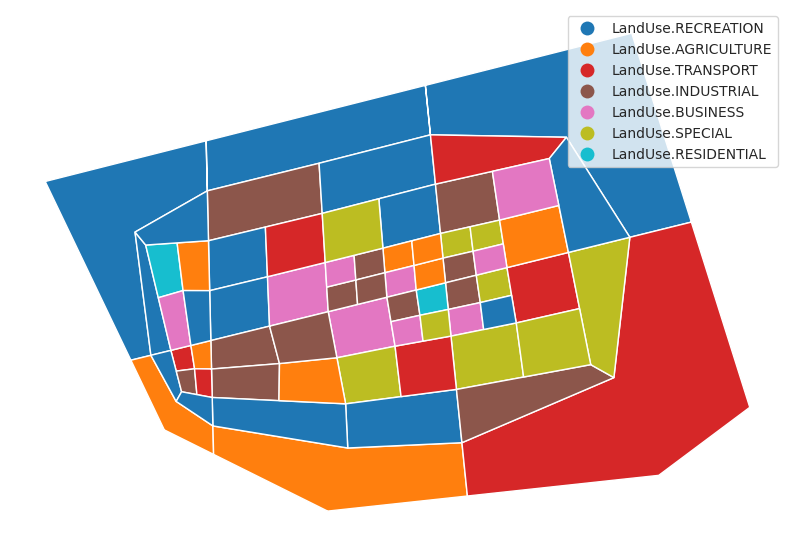

In [63]:
import geopandas as gpd

gdf = luo.to_gdf(blocks_lu)
gdf.plot(column='land_use', legend=True, figsize=(10,10)).set_axis_off()

([<matplotlib.patches.Wedge at 0x7f731f62a740>,
 [Text(0.38324925353784345, 1.0310771114047126, 'recreation'),
  Text(-1.0998992420463884, 0.01488816126256946, 'transport'),
  Text(-0.5560777725614655, -0.9490929937909557, 'agriculture'),
  Text(0.1988870978230685, -1.0818705663430896, 'industrial'),
  Text(0.8145957111772372, -0.739211625538757, 'special'),
  Text(1.0655818991409878, -0.27301138478658005, 'business'),
  Text(1.0994865635475388, -0.033605008234252214, 'residential')])

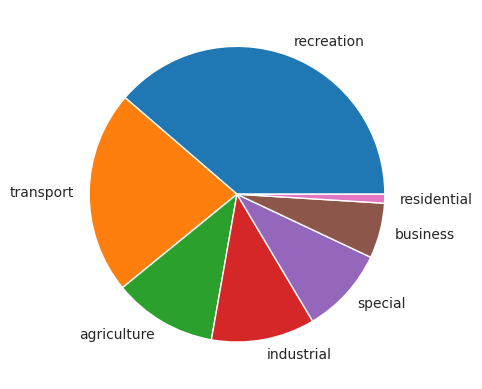

In [64]:
gdf['area'] = gdf.area
gdf['land_use'] = gdf['land_use'].apply(lambda lu : lu.value)
gdf = gdf.groupby('land_use').agg({'area': 'sum'})
gdf = gdf.sort_values('area', ascending=False)
plt.pie(gdf['area'], labels=gdf.index)

## Optimize further

 30%|██▉       | 2991/10000 [06:04<14:14,  8.20it/s]


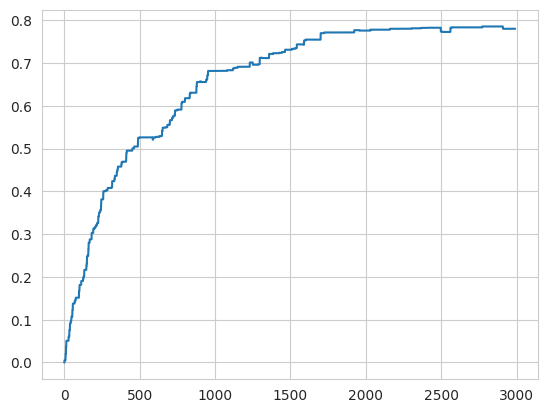

In [65]:
import matplotlib.pyplot as plt

blocks_fsi = {b_id : LU_INDICATORS[lu].fsi_min for b_id, lu in blocks_lu.items()}
blocks_gsi = {b_id : LU_INDICATORS[lu].gsi_min for b_id, lu in blocks_lu.items()}

values = []

def on_iteration(i, variables, indicators, value):
  values.append(value)

ao = AnnealingOptimizer(city_model=city, on_iteration=on_iteration)
X, indicators, value, provisions = ao.calculate(blocks_lu, blocks_fsi, blocks_gsi, {st.name : 1/len(city.service_types) for st in city.service_types}, rate=0.99, max_iter=10000)

plt.plot(values)

In [72]:
value

0.7804213867810509

In [77]:
[f'{st}, {round(v,2)}' for st, v in provisions.items() if v<1]

['school, 0.93',
 'kindergarten, 0.65',
 'polyclinic, 0.34',
 'convenience, 0.5',
 'supermarket, 0.78',
 'cemetery, 0.0',
 'playground, 0.0',
 'beach, 0.35',
 'park, 0.0',
 'zoo, 0',
 'post, 0.59',
 'bakery, 0.0',
 'parking, 0.0',
 'reserve, 0.0',
 'embankment, 0.65',
 'oil_refinery, 0.0',
 'wastewater_plant, 0.0',
 'water_works, 0.08',
 'substation, 0.24',
 'bus_stop, 0.39']

In [73]:
provisions

{'school': 0.9320843091334895,
 'kindergarten': 0.6543778801843319,
 'hospital': 1.0,
 'polyclinic': 0.3404255319148936,
 'pitch': 1.0,
 'swimming_pool': 1.0,
 'stadium': 1.0,
 'theatre': 1.0,
 'museum': 1.0,
 'cinema': 1.0,
 'mall': 1.0,
 'convenience': 0.5023400936037441,
 'supermarket': 0.7838598686268377,
 'cemetery': 0.0,
 'religion': 1.0,
 'market': 1.0,
 'bowling_alley': 1.0,
 'university': 1.0,
 'playground': 0.0,
 'pharmacy': 1.0,
 'fuel': 1.0,
 'beach': 0.34649122807017546,
 'train_building': 1.0,
 'bank': 1.0,
 'lawyer': 1.0,
 'cafe': 1.0,
 'subway_entrance': 1.0,
 'multifunctional_center': 1.0,
 'hairdresser': 1.0,
 'restaurant': 1.0,
 'bar': 1.0,
 'park': 0.0,
 'government': 1.0,
 'recruitment': 1.0,
 'hotel': 1.0,
 'zoo': 0,
 'circus': 1.0,
 'post': 0.5872057936028968,
 'police': 1.0,
 'dog_park': 1.0,
 'hostel': 1.0,
 'bakery': 0.0,
 'parking': 0.0,
 'guest_house': 1.0,
 'reserve': 0.0,
 'sanatorium': 1.0,
 'embankment': 0.6521739130434783,
 'machine-building_plant': 1.0

In [66]:
import pandas as pd

vs = [{'block_id':x.block.id, 'service_type':x.service_type.name, 'is_integrated': x.brick.is_integrated, 'area':x.brick.area, 'capacity': x.brick.capacity, 'count':x.value } for x in X]
vs = filter(lambda v : v['count']>0, vs)
df = pd.DataFrame(list(vs))
df

,block_id,service_type,is_integrated,area,capacity,count
0,0,train_station,False,400.0,20,1
1,0,train_station,False,650.0,40,1
2,0,train_station,False,1300.0,100,1
3,0,museum,False,50000.0,10000,1
4,0,multifunctional_center,True,1200.0,200,1
...,...,...,...,...,...,...
823,62,bank,True,400.0,250,1
824,62,military_kom,False,4000.0,200,1
825,62,guest_house,False,3000.0,50,1
826,62,guest_house,False,15000.0,350,3
